# Multi-class classification problem

__Example of modeling for multiclass classification problem.__

__Training and a test set are provided as csv files.__

__Task: to classify last column that contains 4 classes: [0,1,2,3].__

## Table of contents:
* [1. Data Analysis](#DataAnalysis)
    * [1.1. Train Data Exploration](#TrainDataExploration)
    * [1.2. Test Data Exploration](#TestDataExploration)
    * [1.3. Comparison Train And Test Data](#ComparisonTrainAndTestData)
* [2. Preprocessing](#Preprocessing)
* [3. Baseline Models](#BaselineModels)
* [4. Model Tuning](#ModelTuning)
    * [4.1. Scalers](#Scalers)
    * [4.2. Model Parameters](#ModelParameters)
* [5. Feature selection](#FeatureSelection)
    * [5.1. Most Correlated](#MostCorrelated)
    * [5.2. Most Important](#MostImportant)
* [6. Final Conclusions](#FinalConclusions)    

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import math
import timeit

# Visualiazation
from seaborn import countplot
import matplotlib.pyplot as plt
# import seaborn

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Imputer, LabelBinarizer

from imblearn.pipeline import Pipeline

# Models and multiclasses support
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multiclass import OneVsOneClassifier, OutputCodeClassifier
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Model tuning
from sklearn.model_selection import GridSearchCV

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get train data
train_data = pd.read_csv('input_files/train.csv', sep=',', header=None)
# Get test data
test_data = pd.read_csv('input_files/test.csv', sep=',', header=None)

train_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,-47,0,-5,-27,-11,-19,-2,-33,37,0,...,0,2,-4,-3,4,-23,-68,15,C,0
1,1,1,-2,-3,-1,-3,39,10,0,-1,...,-7,-2,1,6,-2,4,22,2,C,0


In [3]:
test_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,-47,0,-5,-27,-11.0,-19.0,-2.0,-33.0,37,0,...,0,2,-4,-3,4,-23,-68,15,A,0
1,1,1,-2,-3,-1.0,-3.0,39.0,10.0,0,-1,...,-7,-2,1,6,-2,4,22,2,C,0


__NB: Matrix with numerical/categorical values__

## 1. Data Analysis <a class="anchor" id="DataAnalysis"></a>

### 1.1. Train Data Exploration <a class="anchor" id="TrainDataExploration"></a>

In [4]:
# Shape of the data
train_data.shape

(8678, 66)

__NB: Train data matrix has 66 columns (65 features and target)__

In [5]:
# Types of the columns
# train_data.info()
train_data.dtypes.value_counts()

int64     65
object     1
dtype: int64

__NB: There are 64 numerical features, 1 categorical feature and 1 numerical target__

In [6]:
# Statistical information about numerical features
num_stat = train_data.describe().T
print(num_stat['min'].mean(), num_stat['max'].mean(), num_stat['25%'].mean(), num_stat['75%'].mean())
num_stat.head(10)

-102.64615384615385 96.67692307692307 -7.184615384615385 5.8


,count,mean,std,min,25%,50%,75%,max
0,8678.0,-0.540678,18.662137,-116.0,-9.0,-1.0,7.0,111.0
1,8678.0,-0.699931,11.767761,-104.0,-4.0,-1.0,3.0,90.0
2,8678.0,-0.738073,4.980516,-33.0,-3.0,-1.0,2.0,30.0
3,8678.0,-0.695322,7.457261,-75.0,-4.0,-1.0,3.0,55.0
4,8678.0,-0.290389,17.808756,-121.0,-10.0,0.0,10.0,92.0
5,8678.0,-0.584006,25.807365,-122.0,-15.0,-1.0,13.0,127.0
6,8678.0,-1.329339,25.108626,-128.0,-6.0,-1.0,4.0,127.0
7,8678.0,-0.711800,15.420846,-128.0,-8.0,-1.0,6.0,126.0
8,8678.0,-0.647154,18.198702,-110.0,-9.0,-1.0,6.0,127.0
9,8678.0,-0.569717,11.755683,-128.0,-4.0,-1.0,3.0,89.0


__NB: Numerical features are integer, mostly in interval (-100, 100). The biggest part of values are in range (-7, 6)__

In [7]:
# Check columns w-o data
num_stat.index[num_stat['count'] == 0].tolist()

[]

__NB: There are no empty columns__

In [8]:
# Check columns with missing values
num_stat.index[(train_data.shape[0] - num_stat['count']) > 0].tolist()

[]

__NB: There are no columns with missing values__

Share of the classes:
2    25.37
0    25.09
1    24.80
3    24.74
Name: 65, dtype: float64


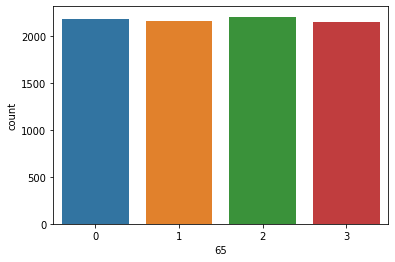

In [9]:
# Check the share of the classes
print('Share of the classes:')
print(round(train_data[65].value_counts(normalize=True)*100, 2))
# Plot the distribution of the classes
%matplotlib inline
countplot(x=65, data=train_data)

__NB: Classes are nicely balanced__

In [10]:
print(train_data[64].value_counts())
print(train_data[65].value_counts())

for l in train_data[64].value_counts().index:
    print(l, ':', train_data[train_data[64]==l][65].value_counts())

D    2202
C    2177
A    2152
B    2147
Name: 64, dtype: int64
2    2202
0    2177
1    2152
3    2147
Name: 65, dtype: int64
D : 2    2202
Name: 65, dtype: int64
C : 0    2177
Name: 65, dtype: int64
A : 1    2152
Name: 65, dtype: int64
B : 3    2147
Name: 65, dtype: int64


__NB: It looks like we have the same information about classes in the columns 64 and 65__

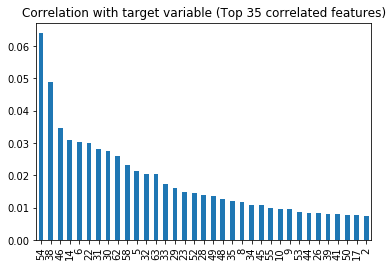

In [11]:
# Correlation
corr = train_data.corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)
# seaborn.pairplot(train_data, palette='husl', diag_kind='kde', kind='reg')

# Correlation to target variable
corr_to_target = abs(corr[65].iloc[:-1].copy())
corr_to_target.sort_values(ascending=False, inplace=True)
# pd.DataFrame(corr_to_target[:13])

corr_to_target[:35].plot(kind='bar', title='Correlation with target variable (Top 35 correlated features)')

In [12]:
# Features with the highest correlation to target
correlated_features = corr_to_target[:13].index.tolist()

__NB: There is some correlation between features and target variable - it is possible to solve the task linearly. 13 features are mostly correlated to target__

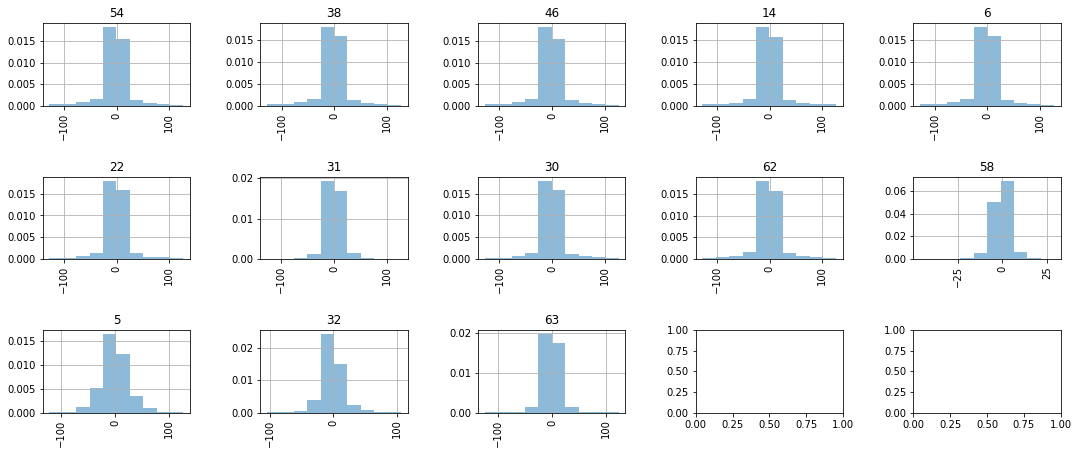

In [13]:
# Distribution of values in most correlated features
nplots, ncols, nrows  = len(correlated_features), 5, int(np.ceil(len(correlated_features)/5))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, int(10*nrows/ncols)))
fig.tight_layout(w_pad=3, h_pad=5)

for n in range(0, len(correlated_features)):
    ax = axes[n//ncols, n%ncols]
    ax.set_title('{}'.format(correlated_features[n]))
    train_data[correlated_features[n]].hist(ax=ax, normed=True, xrot=90, alpha=0.5)

__NB: Values are distributed mostly normally__

### 1.2. Test Data Exploration <a class="anchor" id="TestDataExploration"></a>

In [14]:
test_data.shape

(3000, 66)

In [15]:
test_data.dtypes.value_counts()

int64      56
float64     9
object      1
dtype: int64

__NB: Test data matrix has several different columns formats comparing with train data matrix (float instead of int)__

In [16]:
test_num_stat = test_data.describe().T
# Check columns with missing values in test data
test_num_stat.index[(test_data.shape[0] - test_num_stat['count']) > 0].tolist()

[4, 5, 6, 7, 14, 17, 18, 19, 22]

__NB: There are some missing (NaN) values in the test data__

### 1.3. Comparison Train And Test Data <a class="anchor" id="ComparisonTrainAndTestData"></a>

In [17]:
# Compare test data and the top part of train data (without column 64 and target variable)
num_differences = 0
for i in range(0, 63):
    num_differences = num_differences  + sum(train_data.loc[0:test_data.shape[0] - 1][i] != test_data[i])
    
print('Columns 0-63. Number of defferences: ', num_differences)

Columns 0-63. Number of defferences:  12


In [18]:
# Compare for target column
print('Column 65 (Target). Number of defferences: ', sum(train_data.loc[0:test_data.shape[0]-1][65] != test_data[65]))

Column 65 (Target). Number of defferences:  0


__NB: Top part of the train data matrix (without column number 64) almost fully identical to the train data matrix. There are only 12 diffeences__

In [19]:
# Compare for column 64 (with letters A, B, C, D)
print('Column 64. Number of defferences: ', sum(train_data.loc[0:test_data.shape[0]-1][64] != test_data[64]))

Column 64. Number of defferences:  2264


__NB: Column 64 has a lot of differences in train and test sets__

## 2. Preprocessing <a class="anchor" id="Preprocessing"></a>

__NB: Test data almost fully identical to the top part of the train data.__
__Target variables in both sets have the same values. Column 64 is strange,__ 
__for train set it has doubled infomation with target (65) column.__
__For test set column 64 has a lot of differences, comparing with train set,__
__besides values in other columns almost fully identical.__

__There is no sense to train and test data on th same datasets.__
__Top part of the train set should be cutted.__
__Column 64 excluded from train and test sets due to the reasons explained above.__

In [20]:
# Set for learning
X_train = train_data.iloc[3000:-100, :64]
y_train = train_data.iloc[3000:-100, 65:66]

# Set for testing
X_test = test_data.iloc[:, :64]
y_test = test_data.iloc[:, 65:66]

# Set for final check
X_hold_out = train_data.iloc[-100:, :64]
y_hold_out = train_data.iloc[-100:, 65:66]

In [21]:
# Double check for share of the classes in the new train dataset
print(round(y_train[65].value_counts(normalize=True)*100, 2))

0    25.74
2    25.08
3    24.90
1    24.27
Name: 65, dtype: float64


__NB: There are no missing values in the train data and few in the test data. Lets put Average value instead of missing. Normalising can be applied, due to the little bit different variation of the values in the columns. After normalization, outliers can be deleted with robust scaler__

In [22]:
# Normalization
scaler = MinMaxScaler() 
# No outlier
outlier = RobustScaler()
# Average instead of the missing values
imputer = Imputer(missing_values=np.NAN, axis=1)

## 3. Baseline Models <a class="anchor" id="BaselineModels"></a>

__NB: Several baseline models, including LogRegression, RandomForest, NaiveBayes and XGBoost can be tested. Multiclasses should be taken into account__

In [23]:
# baseline models for multiclass classification 
m_list = [
    ('One-Vs-One', OneVsOneClassifier(LinearSVC(random_state=0))),
    ('Output-Code', OutputCodeClassifier(LinearSVC(random_state=0), code_size=2, random_state=0)),
    ('GradientBoosting', MultiOutputRegressor(GradientBoostingRegressor(random_state=0))),
    ('RandomForest', MultiOutputClassifier(RandomForestClassifier(random_state=1), n_jobs=-1)),
    ('Ridge',  MultiOutputClassifier(RidgeClassifier(random_state=1), n_jobs=-1)),  
    ('LogRegression', MultiOutputClassifier(LogisticRegression(random_state=1), n_jobs=-1)),
    ('NaiveBayes', MultiOutputClassifier( GaussianNB(), n_jobs=-1)),
    ('XGBoost', MultiOutputClassifier(XGBClassifier(random_state=1), n_jobs=-1)),
    ('DecisionTree', MultiOutputClassifier(DecisionTreeClassifier(max_depth = 2), n_jobs=-1))
]


__NB: Best metric for classification problem is roc_auc. Additionally, precision, recall and f1 can be calculated__

In [24]:
# Metrics calculation for multiclass classification 
def MulticlassMetrics(y_test, y_pred, average='macro'):
    ''' Function calculate metrics (roc_auc, f1, precision, recall) for multiclass task '''
    
    # Convert predicted values to integer
    y_pred = y_pred.astype('int32')
    
    # Binarize labels in a one-vs-all fashion
    lb = LabelBinarizer()
    lb.fit(y_test)
    
    # Transform multi-class labels to binary labels
    y_test, y_pred = lb.transform(y_test), lb.transform(y_pred)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    
    return round(roc_auc, 4), round(f1, 4), round(precision, 4), round(recall, 4)

In [25]:
def SecondsToStr(time_taken):
    ''' Function return time in convenient format (hours, minutes, seconds) '''
    
    hours, rest = divmod(time_taken, 3600)
    minutes, seconds = divmod(rest, 60)   
    
    return str(math.trunc(hours)) + ':' + str(math.trunc(minutes)) + ':' + str(round(seconds, 2))

In [26]:
# Pipeline: Train and Predict
def TrainAndPredict(X_train, y_train, X_test, y_test, imputer, scaler, outlier, model, model_name, m_data=[]):
    ''' Function teach the model, calculate metrics and return all the information in the dataframe '''
    
    start = timeit.default_timer()
    
    # Create pipeline
    pipeline = Pipeline([
        ('imputer', imputer), 
        ('scaler' , scaler),
        ('outlier', outlier),
        (model_name, model)])
    
    # Fit model and predict 
    y_pred = pipeline.fit(X_train, y_train).predict(X_test) 
    
    # Calculate the metrics
    roc_auc, f1, precision, recall = MulticlassMetrics(y_test, y_pred)
    
    # Put information about the model to dataframe
    m_data.append([model_name, roc_auc, f1, precision, recall, SecondsToStr(timeit.default_timer() - start)])
    m_df = pd.DataFrame.from_records(m_data, columns=['model', 'roc_auc', 'f1', 'precision', 'recall', 'time'])
    m_df.sort_values(by=['roc_auc'], ascending=False, inplace=True)
    
    return m_df

In [27]:
# Testing of the baseline models
m_data = []
for model_name, model in m_list:
    # print(model_name)
    m_df = TrainAndPredict(X_train, y_train, X_test, y_test, imputer, scaler, outlier, model, model_name, m_data)
   
m_df.head(m_df.shape[0])

,model,roc_auc,f1,precision,recall,time
7,XGBoost,0.9528,0.9297,0.9307,0.9293,0:0:10.39
6,NaiveBayes,0.9237,0.8854,0.8880,0.8853,0:0:1.79
3,RandomForest,0.9192,0.8778,0.8778,0.8788,0:0:4.48
2,GradientBoosting,0.7200,0.5127,0.7231,0.5808,0:0:1.37
8,DecisionTree,0.6034,0.3099,0.4282,0.4067,0:0:0.56
0,One-Vs-One,0.5457,0.3199,0.3214,0.3190,0:0:3.79
5,LogRegression,0.5449,0.3124,0.3139,0.3180,0:0:2.32
4,Ridge,0.5443,0.3110,0.3146,0.3170,0:0:1.6
1,Output-Code,0.5328,0.1954,0.2849,0.2998,0:0:7.76


__NB: XGBoost has the best results for this classification problem__

In [28]:
# Chosen model
model_name = 'Original XGBoost'
model = MultiOutputClassifier(XGBClassifier(random_state=1), n_jobs=-1)

TrainAndPredict(X_train, y_train, X_test, y_test, imputer, scaler, outlier,  model, model_name, []) 

,model,roc_auc,f1,precision,recall,time
0,Original XGBoost,0.9528,0.9297,0.9307,0.9293,0:0:9.61


In [29]:
# Description of the model
model

MultiOutputClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=1, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                                              subsample=

## 4. Model Tuning <a class="anchor" id="ModelTuning"></a>

### 4.1. Scalers <a class="anchor" id="Scalers"></a>

In [30]:
# Try different types of scalers
scalers = [
    ('MinMaxScaler', MinMaxScaler()),
    ('MaxAbsScale', MaxAbsScaler()),
    ('StandardScaler', StandardScaler()),
    ('Normalizer', Normalizer()),
    ('QuantileTransformer', QuantileTransformer()), 
    ('PowerTransformer', PowerTransformer())
]

s_data = []
for scaler_name, scaler in scalers:
    s_df = TrainAndPredict(X_train, y_train, X_test, y_test, imputer, scaler, outlier, model, scaler_name, s_data)
s_df.head(s_df.shape[0])

,model,roc_auc,f1,precision,recall,time
3,Normalizer,0.9620,0.9433,0.9437,0.9431,0:0:15.81
0,MinMaxScaler,0.9528,0.9297,0.9307,0.9293,0:0:9.64
1,MaxAbsScale,0.9528,0.9297,0.9307,0.9293,0:0:8.84
2,StandardScaler,0.9528,0.9297,0.9307,0.9293,0:0:9.07
4,QuantileTransformer,0.9528,0.9297,0.9307,0.9293,0:0:11.56
5,PowerTransformer,0.9528,0.9297,0.9307,0.9293,0:0:11.21


In [31]:
# Chosen scaler
best_scaler = Normalizer()

TrainAndPredict(X_train, y_train, X_test, y_test, imputer, best_scaler, outlier,  model, model_name, []) 

,model,roc_auc,f1,precision,recall,time
0,Original XGBoost,0.962,0.9433,0.9437,0.9431,0:0:13.64


__NB: Normalizer is the best scaler for this task__

### 4.2. Model Parameters <a class="anchor" id="ModelParameters"></a>

In [32]:
# XGBoost list of the params
XGBClassifier().get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

In [33]:
# Tune the model parameters with checking on test dataset
start = timeit.default_timer()

p_data = []
for n_estimators in [100, 300, 500]:
    for max_depht in [3, 4, 8]:
        for learning_rate in [0.001, 0.01, 0.5]:
            model = XGBClassifier(learning_rate = learning_rate, max_depth = max_depht, n_estimators = n_estimators, random_state=1)
            param_set = str(max_depht) + '-' + str(learning_rate) + '-' + str(n_estimators)
            p_df = TrainAndPredict(X_train, y_train, X_test, y_test, imputer, best_scaler, outlier, model, param_set, p_data)
            # print(p_data[len(p_data)-1])
            
print('Time: ', SecondsToStr(timeit.default_timer() - start)) 
p_df.head(5)  


Time:  0:22:15.18


,model,roc_auc,f1,precision,recall,time
17,8-0.5-300,0.9733,0.9600,0.9601,0.9600,0:1:17.67
8,8-0.5-100,0.9731,0.9597,0.9598,0.9598,0:0:19.35
20,3-0.5-500,0.9726,0.9590,0.9592,0.9591,0:0:43.04
26,8-0.5-500,0.9724,0.9587,0.9588,0.9587,0:0:46.2
11,3-0.5-300,0.9722,0.9584,0.9585,0.9584,0:0:30.24


In [34]:
# Best parameters (max_depht - learning_rate - n_estimators)
best_params = p_df[p_df['roc_auc'] == p_df['roc_auc'].max()]['model']
best_params

17    8-0.5-300
Name: model, dtype: object

In [35]:
# Set best scaler and optimal parameters for XGBoost model
best_scaler = Normalizer()

best_model = MultiOutputClassifier(XGBClassifier(
    max_depth=8,
    learning_rate=0.5,
    n_estimators=300,
    random_state=1), n_jobs=-1)

# Calculate metrics for the model with optimal scaler and parameters
TrainAndPredict(X_train, y_train, X_test, y_test, imputer, best_scaler, outlier, best_model, 'Best XGBoost', [])

,model,roc_auc,f1,precision,recall,time
0,Best XGBoost,0.9733,0.96,0.9601,0.96,0:0:50.54


## 5. Feature Selection <a class="anchor" id="FeatureSelection"></a>

### 5.1. Most Correlated <a class="anchor" id="MostCorrelated"></a>

In [36]:
correlated_features

[54, 38, 46, 14, 6, 22, 31, 30, 62, 58, 5, 32, 63]

In [37]:
# Calculate metrics for the best model, for important features only
TrainAndPredict(X_train[correlated_features], y_train, X_test[correlated_features], y_test,
                imputer, best_scaler, outlier, best_model, 'Best XGBoost (correlated only)', [])

,model,roc_auc,f1,precision,recall,time
0,Best XGBoost (correlated only),0.7734,0.6579,0.655,0.6613,0:0:19.17


### 5.2. Most Important <a class="anchor" id="MostImportant"></a>

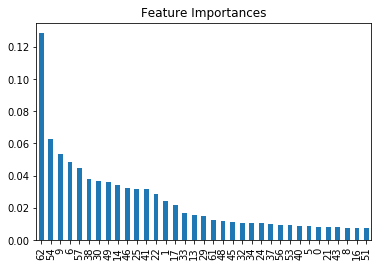

In [38]:
# Fit the best model and find the best features of it
best_model.fit(X_train, y_train)
for model in best_model.estimators_:
    importances = model.feature_importances_

feature_importances = pd.Series(importances, index=[i for i in X_train.columns]).sort_values(ascending=False)

# Visualization
feature_importances[0:35].plot(kind='bar', title='Feature Importances')

__NB: First 16 features are the most important features__

In [39]:
feature_importances.index[:16]

Int64Index([62, 54, 9, 6, 57, 38, 30, 49, 14, 46, 25, 41, 22, 1, 17, 33], dtype='int64')

__NB: Features: 22, 54, 38, 14, 6, 30, 46 are in the both lists. They are important and mostly correlated to target variable__

In [44]:
# Calculate metrics for the best model, for important features only
TrainAndPredict(X_train[feature_importances.index[:16]], y_train, X_test[feature_importances.index[:16]], y_test,
                       imputer, best_scaler, outlier, best_model, 'Best XGBoost (important only)', [])

,model,roc_auc,f1,precision,recall,time
0,Best XGBoost (important only),0.8614,0.7927,0.7948,0.7921,0:0:19.56


__NB: Feature selection can reduce calculation time significantly, but accuracy of forecasting reducing as well (about 10%-20% drop)__

## 6. Final Conclusions <a class="anchor" id="FinalConclusions"></a>

In [41]:
# Final check on test set
TrainAndPredict(X_train, y_train, X_test, y_test, imputer, best_scaler, outlier, best_model, 'Best XGBoost (test)', [])

,model,roc_auc,f1,precision,recall,time
0,Best XGBoost (test),0.9733,0.96,0.9601,0.96,0:0:35.15


In [42]:
# Final check on hold-out set
TrainAndPredict(X_train, y_train, X_hold_out, y_hold_out, imputer, best_scaler, outlier, best_model, 'Best XGBoost (hold_out)', [])

,model,roc_auc,f1,precision,recall,time
0,Best XGBoost (hold_out),0.9863,0.9786,0.9794,0.9792,0:0:32.72


__For this classification task were chosen:__
- scaler: Normalizer
- model: XGBoost (with optimal parameters)
- metrics: roc_auc (and additionally: f1, precision, recall)
    
__Resuts are presented in the table bellow:__

num|test set|roc_auc|f1
------|------|------|------
1|test|0.9733|0.9600
2|hold-out|0.9863|0.9786